<h1 align="center">Call Conversion Predictive Analysis </h1>

<hr style="border:5px solid Black">

<h2 style="color: blue;">Introduction:</h2>

<hr style="border:3px solid Black">

### About:

A big component of Company X’s health insurance vertical is our call marketplace.
 
Customers reach our marketplace by filling out information about themselves on our websites, including their phone number, and then answering our phone call. Once they answer, we auction their call to buyers in our marketplace. The auction winner has the user’s phone call transferred to a member of their sales team.
 
Our buyers’ goal is to sell health insurance policies. Our platform provides the ability to bid based on everything we know about a given user when they answer our call. Users/Calls vary in ‘quality’ (likelihood of purchasing a policy).
 
Attached is a dataset with calls from October 2023 to March 2024. The files provide
+ **health_calls_2023.csv**: calls from Q4 2023
+ **health_calls_2024.csv**: calls from Q1 2024
+ **source.csv**: attributes associated with each source
+ **user_provided_data.csv**: attributes associated with each caller
+ **Data Dictionary.xlsx**: explanations of fields provided in these datasets
se datasets
Note: you can assume the “calls” files are in consistent formats and data types between all files are consistent.

Only one buyer (buyer_id = 63253) has conversion data in the dataset; we do not know the status of calls bought by the other buyers (their conversion values are NA in the dataset). Note that the duration of the call is not known until the call is over, and thus not available for buyers to use in their bidding calculations.


### Objective/Task:

1. **<span style="color:Black">Estimate the likelihood of conversion for every call in the dataset.</span>**
2. **<span style="color:Black">Use the estimate from 1 to explain which types of calls are more likely to convert.</span>**

<hr style="border:5px solid Black">

<h2 style="color: blue;">Table of Contents:</h2>

<hr style="border:3px solid Black">

1. **<span style="color:Blue">Introduction</span>**
    + About
    + Objective/Task
2. **<span style="color:Blue">Table of Contents</span>**
3. **<span style="color:Blue">Libraries</span>**
    + Reading CSV flies
4. **<span style="color:Blue">Data Cleaning</span>**
5. **<span style="color:Blue">Exploratory Data Analysis (Part one)</span>**
6. **<span style="color:Blue">Pre-Processing</span>**
7. **<span style="color:Blue">Model Building</span>**
    + Task 1: Estimate the likelihood of conversion for every call
8. **<span style="color:Blue">Exploratory Data Analysis (Part two)</span>**
    + Task 2: Use the estimate from 1 to explain which types of calls are more likely to convert
9. **<span style="color:Blue">Conclusion</span>**

<hr style="border:5px solid Black">

<h2 style="color: blue;">Libraries</h2>

<hr style="border:3px solid Black">

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

<hr style="border:2px solid Black">

#### Reading CSV files

In [3]:
source = pd.read_csv(r"C:\Users\Yosua\Downloads\source.csv")
user_provided_data = pd.read_csv(r"C:\Users\Yosua\Downloads\user_provided_data.csv")
health_calls_2023 = pd.read_csv(r"C:\Users\Yosua\Downloads\health_calls_2023.csv") # (46162, 7)
health_calls_2024 = pd.read_csv(r"C:\Users\Yosua\Downloads\health_calls_2024.csv") # (53384, 7)

C:\Users\Yosua\AppData\Local\Temp\ipykernel_33720\203272089.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  user_provided_data = pd.read_csv(r"C:\Users\Yosua\Downloads\user_provided_data.csv")


In [4]:
# Stack the health_calls data into one DataFrame.
total_health_calls = pd.concat([health_calls_2023, health_calls_2024])
# Join the other DataFrames,'user_provided_data' and 'source', together.
sample = pd.merge(total_health_calls, user_provided_data, how='inner', on='call_id')
sample = pd.merge(sample, source, on='source_id')
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99546 entries, 0 to 99545
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   call_id            99546 non-null  object 
 1   phone_num_hash     99546 non-null  object 
 2   buyer_id           99546 non-null  float64
 3   source_id          99546 non-null  int64  
 4   time               99546 non-null  object 
 5   call_duration      99546 non-null  int64  
 6   conversion         13619 non-null  float64
 7   state              99546 non-null  object 
 8   currently_insured  816 non-null    float64
 9   connection_type    99546 non-null  object 
 10  browser            99515 non-null  object 
 11  browser_platform   99208 non-null  object 
 12  device             99546 non-null  object 
 13  age                98733 non-null  float64
 14  bmi                314 non-null    float64
 15  coverage_type      7 non-null      object 
 16  credit_rating      0 n

<hr style="border:5px solid Black">

<h2 style="color: blue;">Data Cleaning</h2>

<hr style="border:3px solid Black">

In [5]:
def column_cleanup(dataframe):
    # Convert 'time' column to datetime
    dataframe['time'] = pd.to_datetime(dataframe['time'])
    
    # Extract month from 'time' column
    dataframe['month'] = dataframe['time'].dt.month
    
    # Round down the age to get the age in whole numbers
    dataframe['age'] = dataframe['age'].apply(np.floor)
    
    return dataframe

In [6]:
def remove_null_columns(dataframe):
    null_pct = {}
    for column in dataframe.columns:
        pct_non_null = (dataframe[column].notnull().sum() / len(dataframe)) * 100
        null_pct[column] = pct_non_null
    
    non_null = pd.DataFrame(null_pct.items(), columns=['column_name', 'non_null_pct'])
    
    # Filter out columns where non-null percentage is less than 90%, but keep 'conversion' column
    null_columns = non_null[(non_null['non_null_pct'] < 90) & (non_null['column_name'] != 'conversion')]['column_name'].tolist()
    
    # Drop these columns from the original DataFrame
    cleaned_dataframe = dataframe.drop(columns=null_columns)

    return cleaned_dataframe

In [7]:
sample_cleaned = column_cleanup(sample)
sample_cleaned = remove_null_columns(sample_cleaned)
sample_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99546 entries, 0 to 99545
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   call_id           99546 non-null  object        
 1   phone_num_hash    99546 non-null  object        
 2   buyer_id          99546 non-null  float64       
 3   source_id         99546 non-null  int64         
 4   time              99546 non-null  datetime64[ns]
 5   call_duration     99546 non-null  int64         
 6   conversion        13619 non-null  float64       
 7   state             99546 non-null  object        
 8   connection_type   99546 non-null  object        
 9   browser           99515 non-null  object        
 10  browser_platform  99208 non-null  object        
 11  device            99546 non-null  object        
 12  age               98733 non-null  float64       
 13  gender            98720 non-null  object        
 14  household_income  9896

<hr style="border:5px solid Black">

<h2 style="color: blue;">Exploratory Data Analysis (Part One)</h2>

<hr style="border:3px solid Black">

#### We will explore the data set using only the records with conversions data, or buyer_id = 63253. This will give us an idea of what data we are working with. We will call this data frame 'conversion_df' for simplicity.

In [8]:
coversion_df = sample[sample['conversion'].notnull()]
coversion_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13619 entries, 7 to 99528
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   call_id            13619 non-null  object        
 1   phone_num_hash     13619 non-null  object        
 2   buyer_id           13619 non-null  float64       
 3   source_id          13619 non-null  int64         
 4   time               13619 non-null  datetime64[ns]
 5   call_duration      13619 non-null  int64         
 6   conversion         13619 non-null  float64       
 7   state              13619 non-null  object        
 8   currently_insured  167 non-null    float64       
 9   connection_type    13619 non-null  object        
 10  browser            13612 non-null  object        
 11  browser_platform   13565 non-null  object        
 12  device             13619 non-null  object        
 13  age                13453 non-null  float64       
 14  bmi        

#### We are working with imbalanced data. About 15% converted and 85% did not.

<Figure size 1200x800 with 0 Axes>

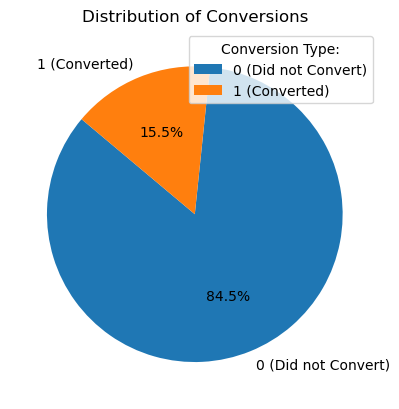

In [9]:
conversion_distribution = coversion_df['conversion'].value_counts().reset_index()
conversion_distribution['conversion'] = conversion_distribution['conversion'].apply(lambda x: '0 (Did not Convert)' if x==0 else '1 (Converted)')

# Plotting the pie chart
plt.figure(figsize=(12, 8))
conversion_distribution.plot(kind='pie', autopct='%1.1f%%', y = 'count', startangle=140, labels=conversion_distribution['conversion'])
plt.title('Distribution of Conversions')
plt.ylabel('')  # Remove the y-label as it's not needed for pie charts
plt.legend(title='Conversion Type:', loc='upper right')

plt.show()

In [10]:
conversion_distribution

,conversion,count
0,0 (Did not Convert),11503
1,1 (Converted),2116


In [11]:
average_call_income = coversion_df.groupby('conversion').agg(average_call_duration=('call_duration', 'mean'),
                            average_household_income=('household_income', 'mean')
                            ).reset_index()
average_call_income

,conversion,average_call_duration,average_household_income
0,0.0,541.572807,410629.958140
1,1.0,1854.707940,42615.479905


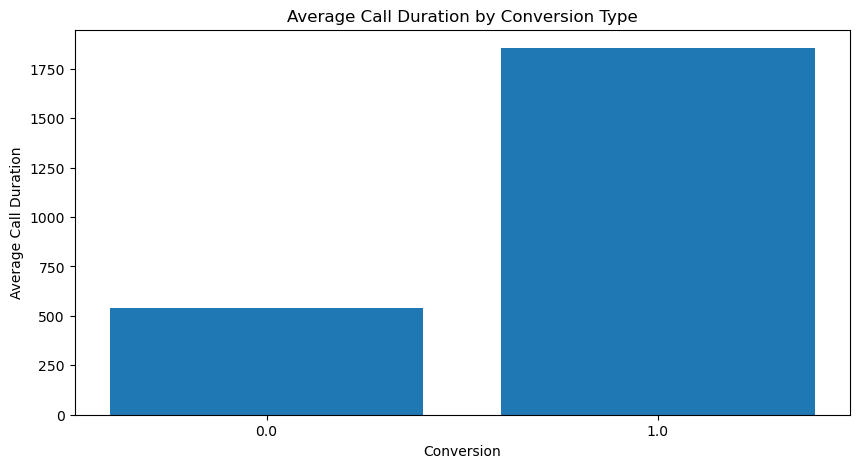

In [12]:
plt.figure(figsize=(10,5))

plt.bar(average_call_income['conversion'].astype(str), average_call_income['average_call_duration'])
plt.title('Average Call Duration by Conversion Type')
plt.xlabel('Conversion')
plt.ylabel('Average Call Duration')
plt.show()

#### This buyer (buyer_id=63253) is active during the holiday season between November to January.

In [13]:
monthly_conversions = coversion_df.groupby('month').agg(converted=('conversion', 'sum'),
                        total_calls=('conversion', 'count'),
                            ).sort_values(by='total_calls', ascending=False).reset_index()
monthly_conversions['conversion_rate'] = monthly_conversions['converted']/monthly_conversions['total_calls']
monthly_conversions

,month,converted,total_calls,conversion_rate
0,1,597.0,3721,0.160441
1,12,520.0,2998,0.173449
2,11,498.0,2912,0.171016
3,2,200.0,1709,0.117028
4,3,115.0,1204,0.095515
5,10,186.0,1075,0.173023


#### **Note:**

This section is just a brief analysis to get a quick idea of the data set we are working with. Further analysis will be conducted in **Exploratory Data Analysis (Part Two)**

<hr style="border:5px solid Black">

<h2 style="color: blue;">Pre-Processing</h2>

<hr style="border:3px solid Black">

#### We will remove colums 'call_id', 'phone_num_hash', 'time', and 'seller_type' because they are basically unique IDs and do not have effects for predition later on. On the other hand, seller_type only contains one value so it is also removed.

In [14]:
sample_cleaned = sample_cleaned.drop(columns=['call_id', 'phone_num_hash', 'time', 'seller_type'], axis=1)

#### Impute the remaining missing values
For categorical values, impute the columns with its mode. For non-categorcal values, impute the columns with its median. This is because the columns are not normally distributed and instead skewed.

In [15]:
def impute_null_values(dataframe):
    # Select categorical and non-categorical columns
    categorical = dataframe.select_dtypes(include='object').columns
    non_categorical = dataframe.select_dtypes(exclude='object').columns
    
    # Impute categorical columns with mode
    for col in categorical:
        mode_value = dataframe[col].mode()[0]
        dataframe[col].fillna(mode_value, inplace=True)
    
    # Impute non-categorical columns with median
    for col in non_categorical:
        if col == 'conversion':
            continue
        median_value = dataframe[col].median() # Median imputation because data is skewed.
        dataframe[col].fillna(median_value, inplace=True)
    
    return dataframe

In [16]:
sample_cleaned = impute_null_values(sample_cleaned)
sample_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99546 entries, 0 to 99545
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   buyer_id          99546 non-null  float64
 1   source_id         99546 non-null  int64  
 2   call_duration     99546 non-null  int64  
 3   conversion        13619 non-null  float64
 4   state             99546 non-null  object 
 5   connection_type   99546 non-null  object 
 6   browser           99546 non-null  object 
 7   browser_platform  99546 non-null  object 
 8   device            99546 non-null  object 
 9   age               99546 non-null  float64
 10  gender            99546 non-null  object 
 11  household_income  99546 non-null  float64
 12  household_size    99546 non-null  int64  
 13  subsidy           99546 non-null  object 
 14  seller_id         99546 non-null  int64  
 15  month             99546 non-null  int32  
dtypes: float64(4), int32(1), int64(4), objec

#### Now we will use Scikitlearn's LabelEncoder() to convert the categorical variables into numeric. This is so we can input these into ML model

In [17]:
def encode_cat_values(dataframe):
        # Select categorical and non-categorical columns
    categorical = dataframe.select_dtypes(include='object').columns

    label_encoder = LabelEncoder()
    for i in categorical:
        dataframe[i] = label_encoder.fit_transform(dataframe[i])
        
    return dataframe

In [18]:
sample_cleaned = encode_cat_values(sample_cleaned)
sample_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99546 entries, 0 to 99545
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   buyer_id          99546 non-null  float64
 1   source_id         99546 non-null  int64  
 2   call_duration     99546 non-null  int64  
 3   conversion        13619 non-null  float64
 4   state             99546 non-null  int32  
 5   connection_type   99546 non-null  int32  
 6   browser           99546 non-null  int32  
 7   browser_platform  99546 non-null  int32  
 8   device            99546 non-null  int32  
 9   age               99546 non-null  float64
 10  gender            99546 non-null  int32  
 11  household_income  99546 non-null  float64
 12  household_size    99546 non-null  int64  
 13  subsidy           99546 non-null  int32  
 14  seller_id         99546 non-null  int64  
 15  month             99546 non-null  int32  
dtypes: float64(4), int32(8), int64(4)
memory

<hr style="border:5px solid Black">

<h2 style="color: blue;">Model Building</h2>

<hr style="border:3px solid Black">

### **Task 1: Estimate the likelihood of conversion for every call**

**Issue:** Only one buyer (buyer_id = 63253) has conversion data and the rest are NaN in the conversion column.  

Our data is sparse as there are a lot more records without conversion data in the data set.

In [19]:
sample['conversion'].value_counts(dropna=False).reset_index() # Our data is sparse

,conversion,count
0,NaN,85927
1,0.0,11503
2,1.0,2116


#### Approach: Binary Classsification for Conversion Prediction
Predict missing values in conversion based on the data provided for buyer_id = 63253 and other available features.
Let's use the 'sample_cleaned' data frame from the pre-processing section earlier as this data frame only includes records with conversion data. We will call this data frame 'cleaned_df'. 

In [20]:
cleaned_df = sample_cleaned[sample_cleaned['buyer_id'] == 63253]
cleaned_df

,buyer_id,source_id,call_duration,conversion,state,connection_type,browser,browser_platform,device,age,gender,household_income,household_size,subsidy,seller_id,month
7,63253.0,3330,303,0.0,36,0,6,2,1,35.0,1,20000.0,1,0,507,10
9,63253.0,3330,22,0.0,9,0,6,2,1,21.0,0,23500.0,3,0,507,10
13,63253.0,3330,74,0.0,35,0,0,0,1,32.0,0,23000.0,2,0,507,10
28,63253.0,3330,1049,0.0,9,0,6,2,1,60.0,0,23500.0,2,0,507,10
34,63253.0,3330,831,0.0,27,1,6,2,1,35.0,0,16000.0,1,0,507,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98160,63253.0,1511688,39,0.0,32,1,2,2,1,40.0,0,30000.0,1,2,507,11
99497,63253.0,2410066,148,0.0,5,0,0,0,1,41.0,0,16000.0,2,0,507,3
99510,63253.0,2410066,133,0.0,40,0,6,2,1,18.0,0,16000.0,1,0,507,3
99516,63253.0,2410066,690,0.0,38,0,0,0,1,61.0,0,16000.0,1,0,507,3


<hr style="border:4px solid Black">

#### No non-categorical columns seem to be normally distributed. The 'age' column is the closest to representing a normally distrubed histogram.

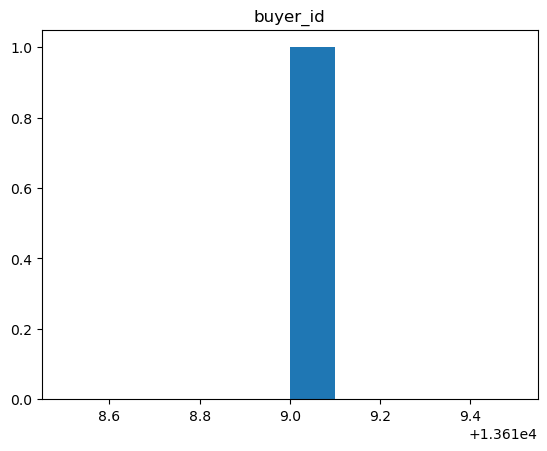

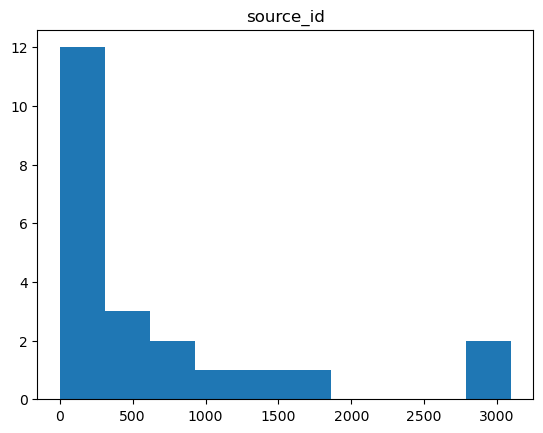

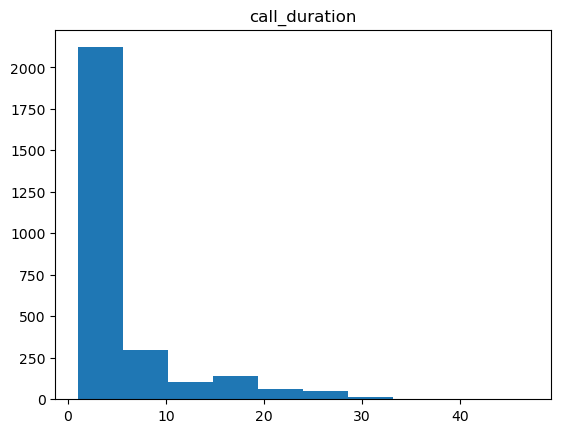

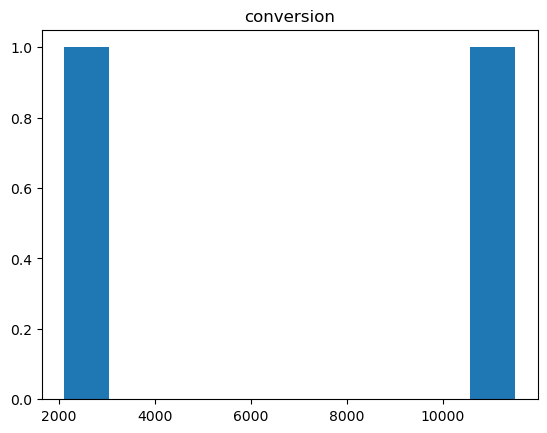

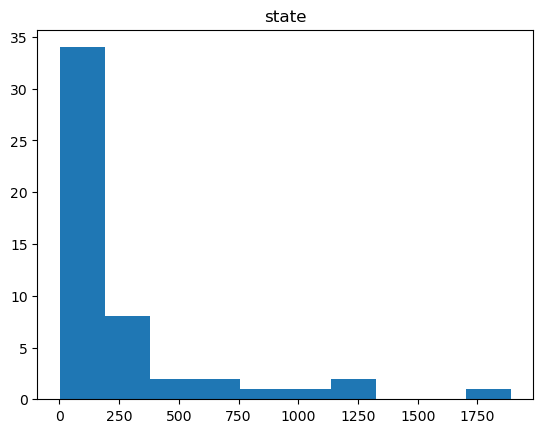

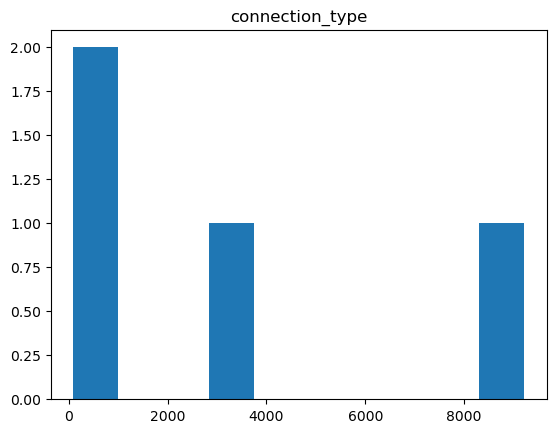

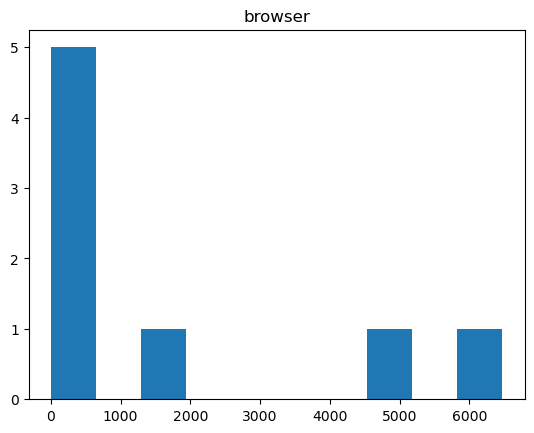

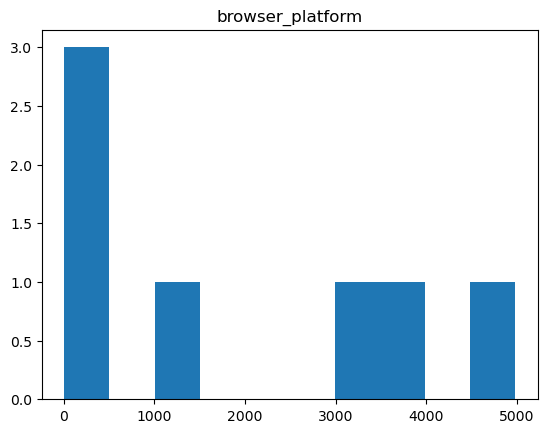

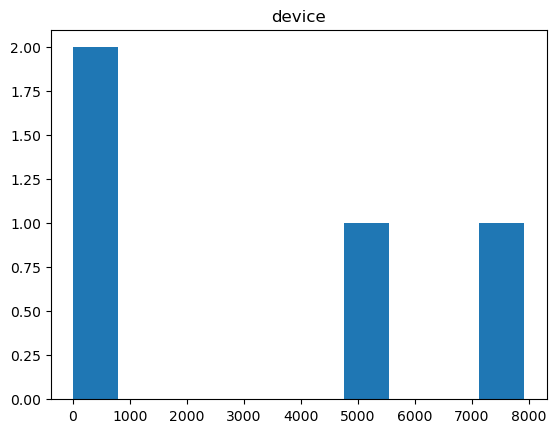

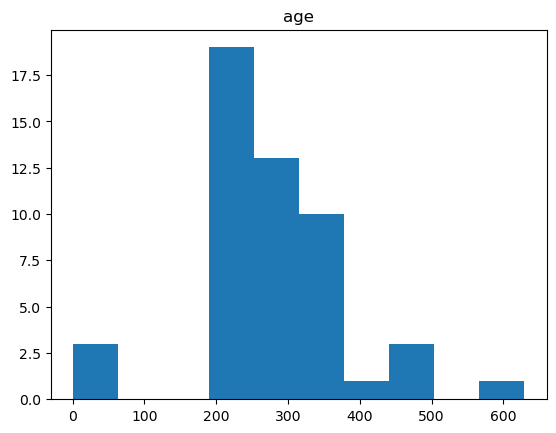

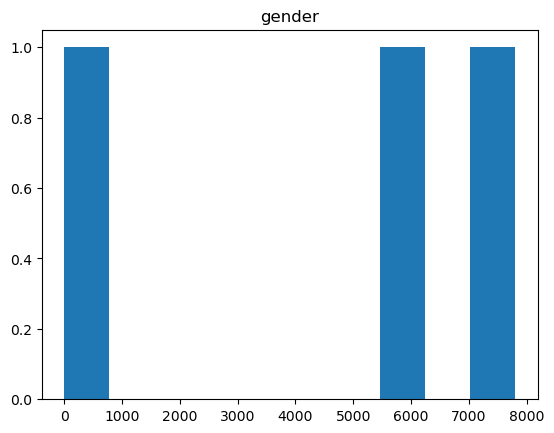

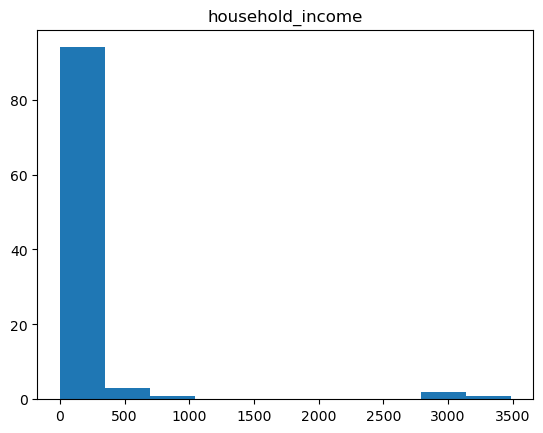

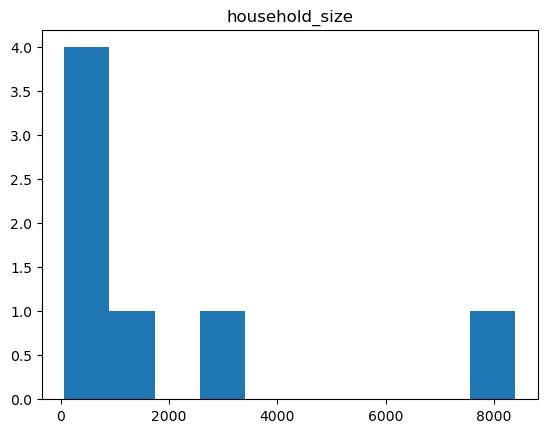

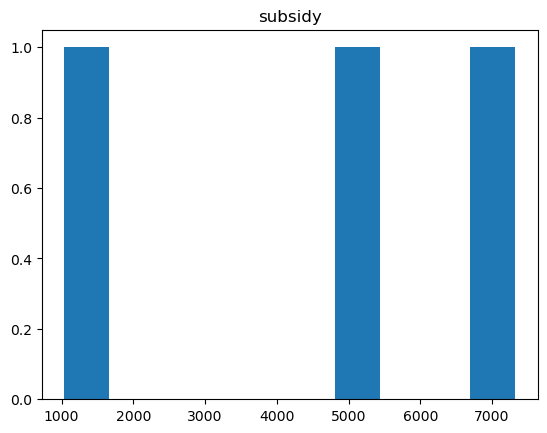

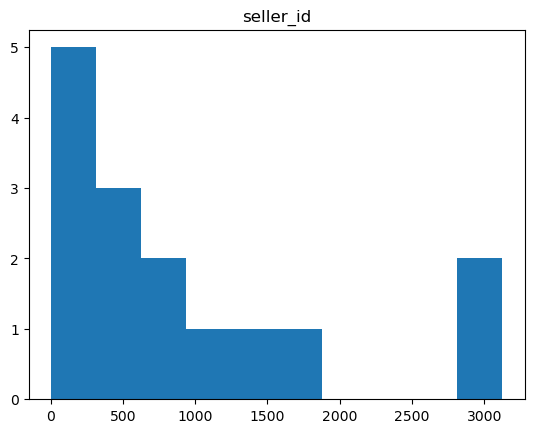

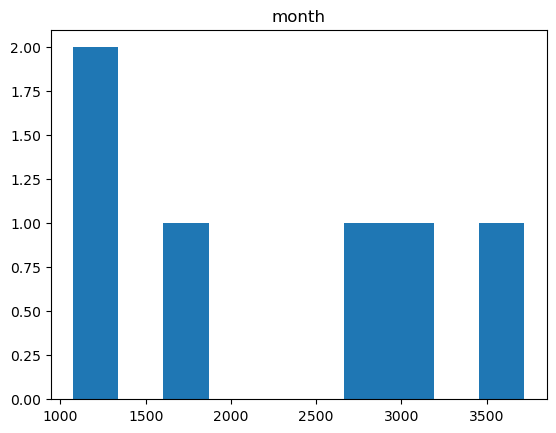

In [21]:
non_categorical = cleaned_df.select_dtypes(exclude='object').columns

for i in non_categorical:
    plt.hist(cleaned_df[i].value_counts())
    plt.title(i)
    plt.show()

<hr style="border:4px solid Black">

In [22]:
cleaned_df[non_categorical].corr(method="pearson")

,buyer_id,source_id,call_duration,conversion,state,connection_type,browser,browser_platform,device,age,gender,household_income,household_size,subsidy,seller_id,month
buyer_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source_id,NaN,1.000000,0.018797,0.011818,0.305233,-0.013433,-0.035651,0.080598,-0.059713,0.036285,0.001922,-0.004788,0.026595,0.014855,0.954857,-0.155216
call_duration,NaN,0.018797,1.000000,0.547599,-0.020911,-0.052100,-0.040525,0.138862,-0.112537,0.134529,0.004620,-0.006413,0.033649,0.127581,0.045757,0.076287
conversion,NaN,0.011818,0.547599,1.000000,-0.017304,-0.045844,-0.012794,0.106852,-0.073018,0.092969,0.020094,-0.003588,-0.011895,0.107151,0.031651,0.042048
state,NaN,0.305233,-0.020911,-0.017304,1.000000,0.005126,-0.034699,0.024810,-0.020076,0.014600,0.003406,-0.002809,0.021574,0.001672,0.281043,-0.042979
connection_type,NaN,-0.013433,-0.052100,-0.045844,0.005126,1.000000,-0.002718,-0.090367,0.082125,-0.054290,0.004460,-0.005376,-0.011973,0.015440,-0.023615,-0.002897
browser,NaN,-0.035651,-0.040525,-0.012794,-0.034699,-0.002718,1.000000,-0.166607,0.304402,-0.235830,-0.048270,-0.007474,0.006024,-0.021374,-0.027457,-0.031565
browser_platform,NaN,0.080598,0.138862,0.106852,0.024810,-0.090367,-0.166607,1.000000,-0.754807,0.065684,0.001912,-0.010513,0.020300,0.049437,0.106432,0.042677
device,NaN,-0.059713,-0.112537,-0.073018,-0.020076,0.082125,0.304402,-0.754807,1.000000,-0.075728,-0.009140,0.004874,-0.018300,-0.039099,-0.078697,-0.034662
age,NaN,0.036285,0.134529,0.092969,0.014600,-0.054290,-0.235830,0.065684,-0.075728,1.000000,0.000187,0.011861,-0.015596,0.117736,0.037233,0.070623


No variables seem to be correlated. call_duration to conversion seems to be the highest correlated variables.

#### We can remove buyer_id because the data frame only contains one buyer.

In [23]:
cleaned_df = cleaned_df.drop(columns = ['buyer_id'])

In [24]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13619 entries, 7 to 99528
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   source_id         13619 non-null  int64  
 1   call_duration     13619 non-null  int64  
 2   conversion        13619 non-null  float64
 3   state             13619 non-null  int32  
 4   connection_type   13619 non-null  int32  
 5   browser           13619 non-null  int32  
 6   browser_platform  13619 non-null  int32  
 7   device            13619 non-null  int32  
 8   age               13619 non-null  float64
 9   gender            13619 non-null  int32  
 10  household_income  13619 non-null  float64
 11  household_size    13619 non-null  int64  
 12  subsidy           13619 non-null  int32  
 13  seller_id         13619 non-null  int64  
 14  month             13619 non-null  int32  
dtypes: float64(3), int32(8), int64(4)
memory usage: 1.2 MB


<hr style="border:3px solid Black">

In [25]:
# features and target variables
X = cleaned_df.drop(columns = 'conversion', axis=1)
y = cleaned_df['conversion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print("accuracy score: ", accuracy_score(y_test, y_pred)) 
print("AUC score: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2142  156]
 [ 211  215]]
accuracy score:  0.8652716593245228
AUC score:  0.7184048590936392
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      2298
         1.0       0.58      0.50      0.54       426

    accuracy                           0.87      2724
   macro avg       0.74      0.72      0.73      2724
weighted avg       0.86      0.87      0.86      2724



In [26]:
from sklearn.model_selection import cross_val_score

cv_score = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(cv_score)

avg_cv_score = cv_score.mean()
print("average cv score: ", avg_cv_score)

[0.87471317 0.86782928 0.87195961 0.86920606 0.87287747]
average cv score:  0.871317117944011


In [27]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [28]:
# features and target variables
X = cleaned_df.drop(columns = 'conversion', axis=1)
y = cleaned_df['conversion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
rf = RandomForestClassifier(random_state=42)

# Train the model using the resampled training data
rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print("accuracy score: ", accuracy_score(y_test, y_pred)) 
print("AUC score: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2042  256]
 [ 143  283]]
accuracy score:  0.8535242290748899
AUC score:  0.7764590151877321
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91      2298
         1.0       0.53      0.66      0.59       426

    accuracy                           0.85      2724
   macro avg       0.73      0.78      0.75      2724
weighted avg       0.87      0.85      0.86      2724



It is clear that the imbalanced data we are working with pose a problem for our model. Before sampling, we can see in our confusion matrix that the number of false positive instances (type 1 error)  are very high. Our classifcation report shows the values for precision, recall, and f1-score for predicting a call to convert to be relatively low. After applying SMOTE (Synthetic Minority Over-sampling Technique) to address the class imbalance, the model improved but just slightly.

The accuracy score in this case is not reliable as it does not reflect how the model performs when working with imbalanced data sets. We see that the accuracy score after sampling actually dropped even though the confusion matrix and classification score tells better results from the its previous.

Let's try applying SMOTE and undersampling approach to see if the results improve:

In [29]:
# features and target variables
X = cleaned_df.drop(columns = 'conversion', axis=1)
y = cleaned_df['conversion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Initialize SMOTE and Random UnderSampler
smote = SMOTE(random_state=42)
under_sampler = RandomUnderSampler(random_state=42)

# Create a pipeline with SMOTE and Random UnderSampler
pipeline = Pipeline([
    ('smote', smote),
    ('under_sampler', under_sampler)
])

# Apply the pipeline to the training data
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Train the Random Forest classifier on the resampled data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print("accuracy score: ", accuracy_score(y_test, y_pred)) 

[[2026  272]
 [ 132  294]]
accuracy score:  0.8516886930983847


In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      2298
         1.0       0.52      0.69      0.59       426

    accuracy                           0.85      2724
   macro avg       0.73      0.79      0.75      2724
weighted avg       0.87      0.85      0.86      2724



+ As a result from the confusion matrix and classification report, it does not seem to make much of a difference..

<hr style="border:3px solid Black">

I have chosen to utilize oversampling instead of undersampling because I felt that the data set we are working with would not be considered a large data set. Because of this, reducing the data in the majority class would also reduce valuable information.



In [31]:
cleaned_df['conversion'].value_counts()

conversion
0.0    11503
1.0     2116
Name: count, dtype: int64

In [32]:
# features and target variables
X = cleaned_df.drop(columns = 'conversion', axis=1)
y = cleaned_df['conversion']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [33]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
print(Counter(y))
rus = RandomOverSampler(random_state=42)
X_over, y_over = rus.fit_resample(X,y)
print(Counter(y_over))

Counter({0.0: 11503, 1.0: 2116})
Counter({0.0: 11503, 1.0: 11503})


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18404, 14)
(18404,)
(4602, 14)
(4602,)


In [35]:
rf = RandomForestClassifier(random_state=42)

# Train the model using the resampled training data
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print("accuracy score: ", accuracy_score(y_test, y_pred)) 
print("AUC score: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2082  237]
 [   0 2283]]
accuracy score:  0.9485006518904824
AUC score:  0.9489003880983182
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95      2319
         1.0       0.91      1.00      0.95      2283

    accuracy                           0.95      4602
   macro avg       0.95      0.95      0.95      4602
weighted avg       0.95      0.95      0.95      4602



Unlike SMOTE, the RandomOverSampler method creates copies of the existing sample rather than creating synthetic samples. After implementing  RandomOverSampler we see that the results are much better. Some things to take note of is that the RandomOverSampler approach is more vulnerable to overfitting the model. We will go with this for simplicity of the project. 

In [36]:
# Predict and evaluate
train_predictions = rf.predict(X_train)
test_predictions = rf.predict(X_test)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

Training Accuracy: 1.00
Test Accuracy: 0.95


### **Using the model to estimate the likelihood of conversion for every call in the original data set**

In [37]:
non_null_conversions_df = cleaned_df.drop(columns= 'conversion') # 14 columns after this
conversion_pred = rf.predict(non_null_conversions_df)
conversion_proba = rf.predict_proba(non_null_conversions_df)[:, 1]

non_null_conversions_df['conversion_pred'] = conversion_pred
non_null_conversions_df['conversion_proba'] = conversion_proba


null_cleaned_df = sample_cleaned[sample_cleaned['conversion'].isnull()] # We take the preprocessed data for the remaining null conversions
null_conversions_df = null_cleaned_df.drop(columns= ['conversion', 'buyer_id'])
null_conversion_pred = rf.predict(null_conversions_df)
null_conversion_proba = rf.predict_proba(null_conversions_df)[:, 1]

null_conversions_df['conversion_pred'] = null_conversion_pred
null_conversions_df['conversion_proba'] = null_conversion_proba

# Concatenate the two data frames to show the conversion_pred and conversion_proba on all calls recorded in the data set.
final_sample = pd.concat([null_conversions_df, non_null_conversions_df])

# Finally we pull the conversion_pred and conversion_proba columns into the original data set.
final_df = pd.concat([sample, final_sample.iloc[:, -2:]], axis=1)
final_df.head()

,call_id,phone_num_hash,buyer_id,source_id,time,call_duration,conversion,state,currently_insured,connection_type,...,household_income,married,household_size,subsidy,weight,seller_id,seller_type,month,conversion_pred,conversion_proba
0,CA25123ac8ae1550d20702684e9b383a9d,1E203B4634DCA46E4D4045C9CCAB0C14177B510A19AB14...,34844.0,3330,2023-10-01 00:18:54,145,NaN,PA,NaN,broadband,...,23500.0,NaN,1,yes,NaN,507,owned_and_operated,10,0.0,0.00
1,CA0bf360c2e450496ab7f9827ca53c2782,C0A651D4E963BF925E4B641C456C219944346F7D0C2C1B...,66836.0,3330,2023-10-01 12:19:35,1705,NaN,KY,NaN,broadband,...,40000.0,NaN,1,yes,NaN,507,owned_and_operated,10,1.0,0.73
2,CA2c303f8186fcf2783398916949fbdfbc,6FF94E1E927AB3269BA8ACB0DC13FDB4CD5E5D6C26563C...,1987.0,3330,2023-10-01 18:41:09,1,NaN,LA,NaN,cellular,...,40000.0,NaN,2,yes,NaN,507,owned_and_operated,10,0.0,0.02
3,CA694b6e2c7ed47d0ccb070e63339b3703,B3B0CE54CBB8C872CFEFF86EC3767A383200537A5C0094...,2486.0,3330,2023-10-01 22:34:43,156,NaN,AZ,NaN,cellular,...,100000.0,NaN,4,yes,NaN,507,owned_and_operated,10,0.0,0.03
4,CAe560088516553c703a6e2426a3295994,EB098A09FA9EF17E3D34B97168EBF924BF253A81DD32A2...,1728.0,3330,2023-10-02 06:04:34,159,NaN,GA,NaN,broadband,...,9500.0,NaN,1,medicaid,NaN,507,owned_and_operated,10,0.0,0.00


In [38]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99546 entries, 0 to 99545
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   call_id            99546 non-null  object        
 1   phone_num_hash     99546 non-null  object        
 2   buyer_id           99546 non-null  float64       
 3   source_id          99546 non-null  int64         
 4   time               99546 non-null  datetime64[ns]
 5   call_duration      99546 non-null  int64         
 6   conversion         13619 non-null  float64       
 7   state              99546 non-null  object        
 8   currently_insured  816 non-null    float64       
 9   connection_type    99546 non-null  object        
 10  browser            99515 non-null  object        
 11  browser_platform   99208 non-null  object        
 12  device             99546 non-null  object        
 13  age                98733 non-null  float64       
 14  bmi   

<hr style="border:5px solid Black">

<h2 style="color: blue;">Exploratory Data Analysis (Part Two)</h2>

<hr style="border:3px solid Black">

### **Task 2: Use the estimate from 1 to explain which types of calls are more likely to convert**

**Reminder:** 
+ Calls vary in "quality" (likelihood of purchasing a policy)
+ More likely to convert (purchase) = More valuable 

#### We can see that the longer the call duration the more likely the calls converts.

In [39]:
duration_conversion = final_sample.groupby('conversion_pred')['call_duration'].mean().reset_index().rename(
    columns={'call_duration': 'average_call_time'})
duration_conversion['conversion_pred'] = duration_conversion['conversion_pred'].apply(lambda x: 'Did not Convert' if x==0 else 'Converted')
duration_conversion

,conversion_pred,average_call_time
0,Did not Convert,386.992828
1,Converted,2029.501553


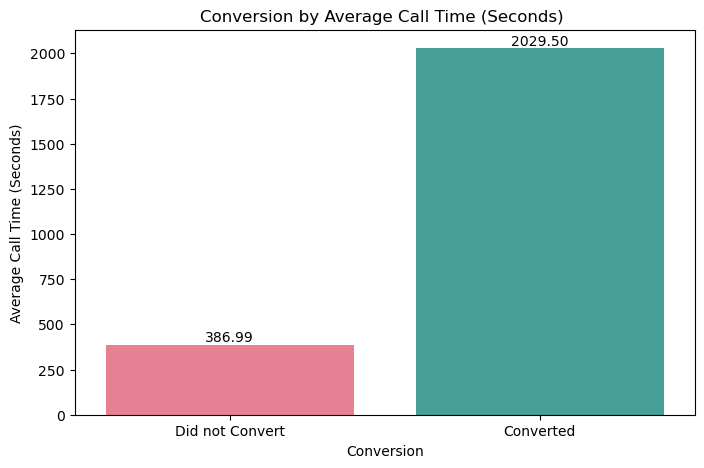

In [40]:
plt.figure(figsize=(8, 5))
x =sns.barplot(x='conversion_pred', y='average_call_time', data=duration_conversion, palette='husl')
plt.title('Conversion by Average Call Time (Seconds) ')
plt.xlabel('Conversion')
plt.ylabel('Average Call Time (Seconds)')
plt.bar_label(x.containers[0], fmt='%.2f', fontsize=10)
plt.show()

### Explore The Conversion by States

In [41]:
state_conversion = final_df.groupby('state').agg(total_converted=('conversion_pred', 'sum'),
                              total_action=('conversion_pred', 'count')
                            ).reset_index()
state_conversion['conversion_rate'] = state_conversion['total_converted']/ state_conversion['total_action'] * 100

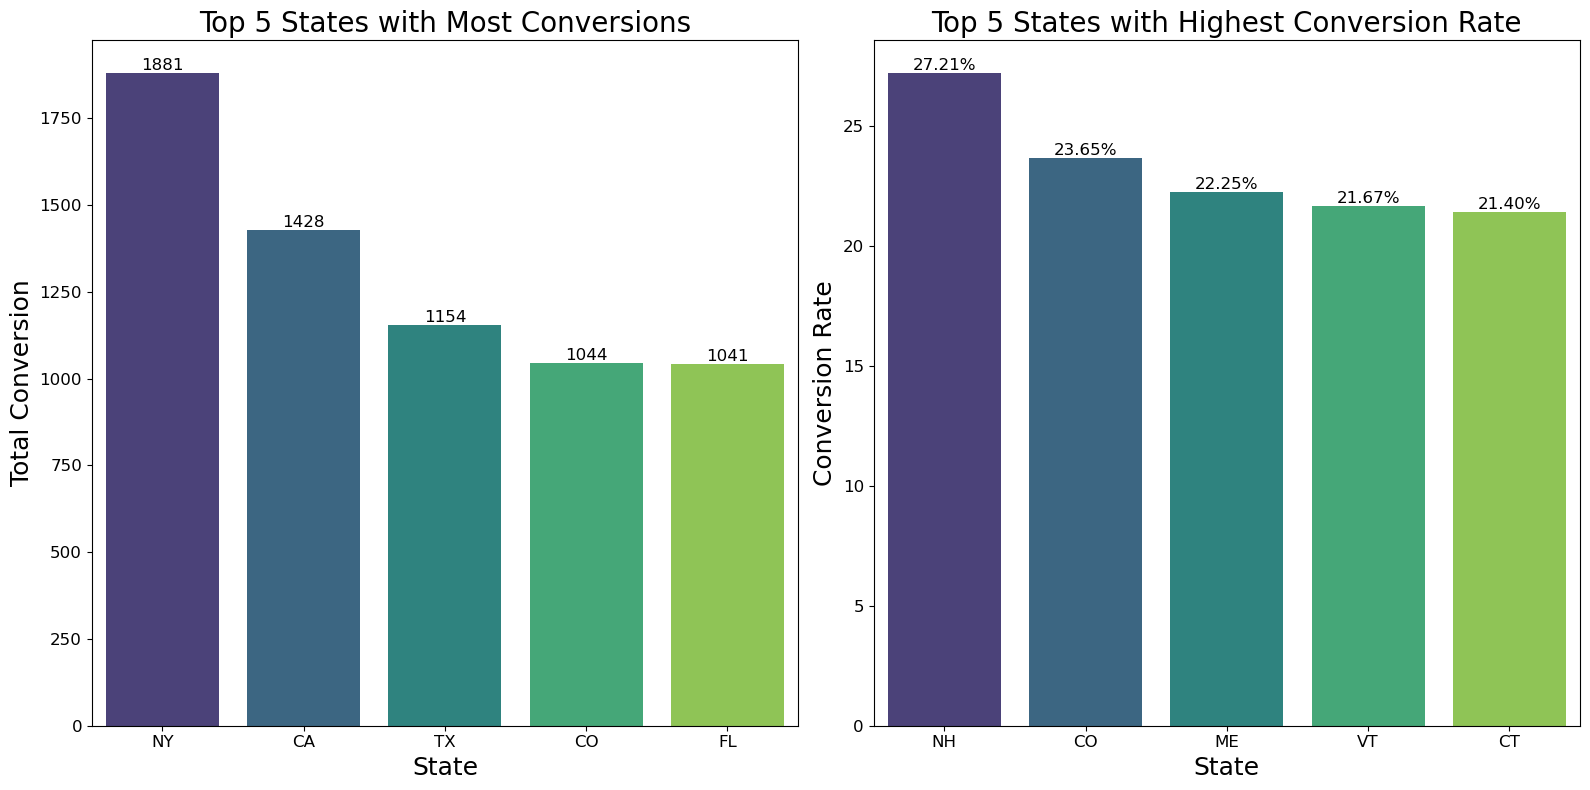

In [42]:
converted_sorted = state_conversion.sort_values(by='total_converted', ascending=False)
conversion_rate_sorted = state_conversion.sort_values(by='conversion_rate', ascending=False)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first bar plot
sns.barplot(x='state', y='total_converted', data=converted_sorted[:5], ax=axes[0], palette='viridis')
axes[0].set_title('Top 5 States with Most Conversions', fontsize=20)
axes[0].set_xlabel('State', fontsize = 18)
axes[0].set_ylabel('Total Conversion', fontsize = 18)
axes[0].bar_label(axes[0].containers[0], fontsize=12)
axes[0].tick_params(labelsize=12)

# Plot the second bar plot
sns.barplot(x='state', y='conversion_rate', data=conversion_rate_sorted[:5], ax=axes[1], palette='viridis')
axes[1].set_title('Top 5 States with Highest Conversion Rate', fontsize=20)
axes[1].set_xlabel('State', fontsize = 18)
axes[1].set_ylabel('Conversion Rate', fontsize = 18)
axes[1].bar_label(axes[1].containers[0], fmt='%.2f%%', fontsize=12)
axes[1].tick_params(labelsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#### **Insights:**

+ It is clear that the bigger states are more likely to have converted in numbers due to its higher volume of calls. This makes sense as these states are highly populated.
+ We notice that CO (Colorado) ranks 2nd in conversion rate at about 24% while also being 4th in most conversions. In fact, they are 7th in total action (total number of conversion data recorded in the data set).
  + total_action = total calls recorded in the data set

In [43]:
state_conversion.sort_values(by='total_action', ascending=False)[:7]

,state,total_converted,total_action,conversion_rate
34,NY,1881.0,10489,17.933073
4,CA,1428.0,10093,14.148420
43,TX,1154.0,6720,17.172619
9,FL,1041.0,5631,18.486947
19,MA,1035.0,5176,19.996136
38,PA,905.0,4833,18.725429
5,CO,1044.0,4414,23.652016


### **Exploring The Age Range**

In [44]:
final_df['age'].value_counts().sort_values()
bin_edges = [0, 20, 30, 40, 50, 60, 70, float('inf')]
bin_labels = ['Before 20s', '20s', '30s', '40s', '50s', '60', '70+']
final_df['age_range'] = pd.cut(final_df['age'], bins=bin_edges, labels=bin_labels, include_lowest=True)

age_conversion = final_df.groupby('age_range').agg(conversion_probabiity=('conversion_proba', 'mean'),
                                  total_converted=('conversion_pred', 'sum'),
                                  total_actions=('conversion_pred', 'count')
                            ).reset_index()
age_conversion['conversion_rate%'] = age_conversion['total_converted']/ age_conversion['total_actions'] 
age_conversion

C:\Users\Yosua\AppData\Local\Temp\ipykernel_33720\1182584315.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_conversion = final_df.groupby('age_range').agg(conversion_probabiity=('conversion_proba', 'mean'),


,age_range,conversion_probabiity,total_converted,total_actions,conversion_rate%
0,Before 20s,0.107823,331.0,4621,0.071630
1,20s,0.171757,3973.0,25276,0.157185
2,30s,0.170840,3195.0,20113,0.158852
3,40s,0.176429,3008.0,17684,0.170097
4,50s,0.213722,4488.0,20857,0.215180
5,60,0.255139,2702.0,10177,0.265501
6,70+,0.006000,0.0,5,0.000000


C:\Users\Yosua\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Yosua\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Conversion Metrics by Age Range')

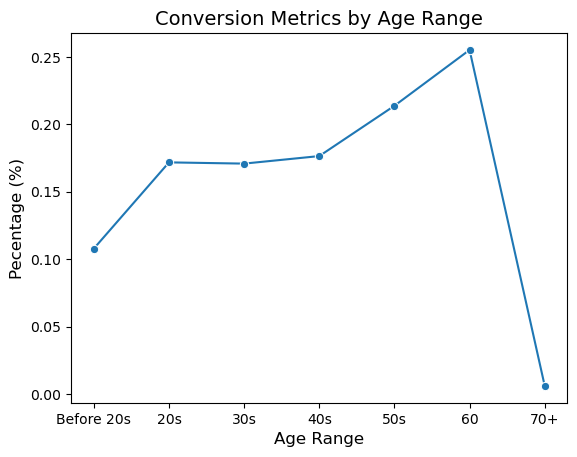

In [45]:
sns.lineplot(x='age_range', y='conversion_probabiity', data=age_conversion, marker='o', linestyle='-')

plt.xlabel('Age Range', fontsize=12)
plt.ylabel('Pecentage (%)', fontsize=12)
plt.title('Conversion Metrics by Age Range', fontsize=14)

#### **Insights:**

+ We can see that the market is dominated by calls from clients in their 20s and 50s. 
+ It is more likely that a client approaching their 60s would convert.
+ Not much to say for those younger than 20 and older than 70 as they aren't our targeted clients.

### **Exploring the website that the caller came from (seller_id)**

+ seller_id = seller website the caller came from

In [46]:
final_df['seller_id'].value_counts().reset_index()

,seller_id,count
0,507,25120
1,325,16696
2,506,14798
3,4127,9508
4,530,8912
5,783,4294
6,387,3966
7,782,3371
8,786,2762
9,514,2222


In [47]:
seller_website = final_df.groupby('seller_id').agg(conversion_probabiity=('conversion_proba', 'mean'),
                                  total_converted=('conversion_pred', 'sum'),
                                  total_actions=('conversion_pred', 'count')
                            ).reset_index()
seller_website['conversion_rate%'] = seller_website['total_converted']/ seller_website['total_actions'] 
seller_website.sort_values(by='conversion_probabiity', ascending=False)

,seller_id,conversion_probabiity,total_converted,total_actions,conversion_rate%
0,1,0.386667,1.0,3,0.333333
16,1094,0.271997,365.0,1417,0.257586
10,782,0.264037,865.0,3371,0.256600
18,4127,0.243085,2255.0,9508,0.237169
6,520,0.226701,192.0,782,0.245524
12,785,0.224390,508.0,2157,0.235512
3,506,0.223467,3285.0,14798,0.221989
11,783,0.218666,897.0,4294,0.208896
15,1093,0.215519,379.0,1877,0.201918
1,325,0.215219,3448.0,16696,0.206517


#### **Insights:**

+ We are dealing with a case where we high conversaion rate meets low traffic. Specifically in our case, a few of the website from where the call came from has a high probability of converting but low number in traffic.
+ From a quick glance, we see that seller_id 782 and 4127 has a high likelihood of conversion with a decent amount of traffic.
+ From our previous analysis, I am going to check the states that came to call from the website(seller 782).

In [48]:
final_df[final_df['seller_id'] == 782]['state'].value_counts().reset_index().rename(columns={'count':'traffic_count'})

,state,traffic_count
0,CO,3344
1,MO,5
2,KS,3
3,CA,2
4,AR,2
5,MT,2
6,AL,2
7,IL,2
8,NE,1
9,TX,1


+ Surely enough after looking into Colorado, the top website in Colorado is seller_id = 782.

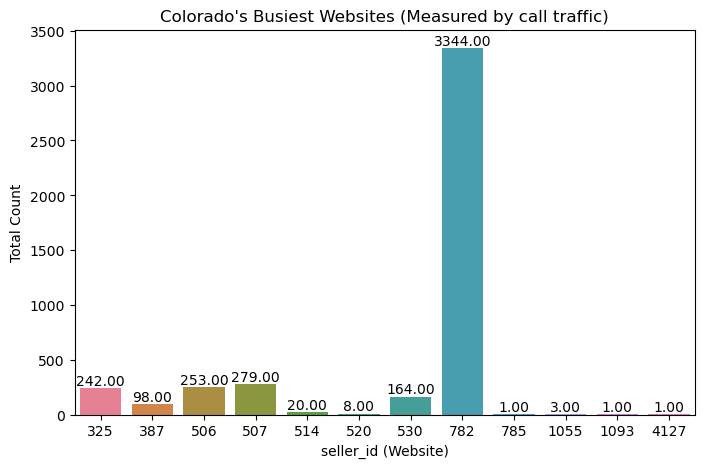

In [49]:
CO_websites = final_df[final_df['state'] == 'CO']['seller_id'].value_counts().reset_index().rename(columns={'count':'freq'}).sort_values(
    by='freq', ascending=False)

plt.figure(figsize=(8, 5))
x =sns.barplot(x='seller_id', y='freq', data=CO_websites, palette='husl')
plt.title("Colorado's Busiest Websites (Measured by call traffic)")
plt.xlabel('seller_id (Website)')
plt.ylabel('Total Count')
plt.bar_label(x.containers[0], fmt='%.2f', fontsize=10)
plt.show()

### Other things to look at: Household Income

In [50]:
final_df.columns

Index(['call_id', 'phone_num_hash', 'buyer_id', 'source_id', 'time',
       'call_duration', 'conversion', 'state', 'currently_insured',
       'connection_type', 'browser', 'browser_platform', 'device', 'age',
       'bmi', 'coverage_type', 'credit_rating', 'current_company', 'gender',
       'height', 'household_income', 'married', 'household_size', 'subsidy',
       'weight', 'seller_id', 'seller_type', 'month', 'conversion_pred',
       'conversion_proba', 'age_range'],
      dtype='object')

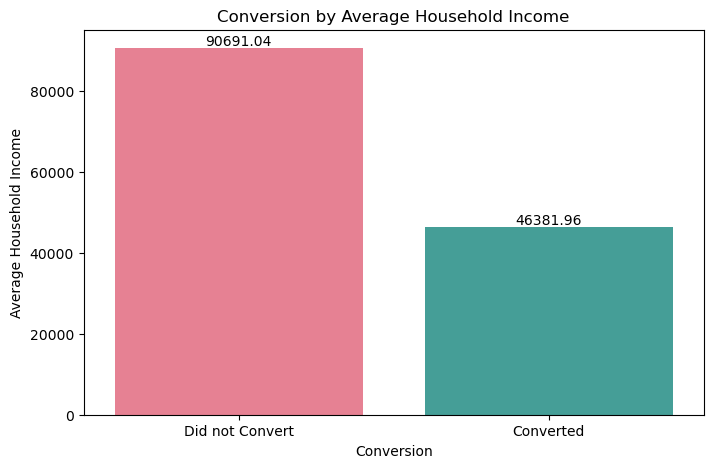

In [51]:
duration_conversion = final_sample.groupby('conversion_pred')['household_income'].mean().reset_index().rename(
    columns={'household_income': 'average_household_income'})
duration_conversion['conversion_pred'] = duration_conversion['conversion_pred'].apply(lambda x: 'Did not Convert' if x==0 else 'Converted')
duration_conversion['average_household_income'] = duration_conversion['average_household_income'].round(2)
duration_conversion

plt.figure(figsize=(8, 5))
x =sns.barplot(x='conversion_pred', y='average_household_income', data=duration_conversion, palette='husl')
plt.title('Conversion by Average Household Income')
plt.xlabel('Conversion')
plt.ylabel('Average Household Income')
plt.bar_label(x.containers[0], fmt='%.2f', fontsize=10)
plt.show()

#### **Insights:**

We can see that the callers who did not convert have on average a higher household income. The average income of those who did not convert is nearly double the average household income of those who converted. This makes sense as those with a lesser income are more likely to lack coverage compared to higher income groups. Due of this, they are in search of the better health plan in which our services could potentially offer.

Does this mean lower household income callers are more valuable than higher household income callers?

A caller is more valuable if they are more likely to convert. However, other factors should be considered such as quantity of conversions and its conversion rate.

C:\Users\Yosua\AppData\Local\Temp\ipykernel_33720\3170647206.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_binned_conversion = final_df.groupby('household_income_bin').agg(conversion_probabiity=('conversion_proba', 'mean'),
C:\Users\Yosua\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\Yosua\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curren

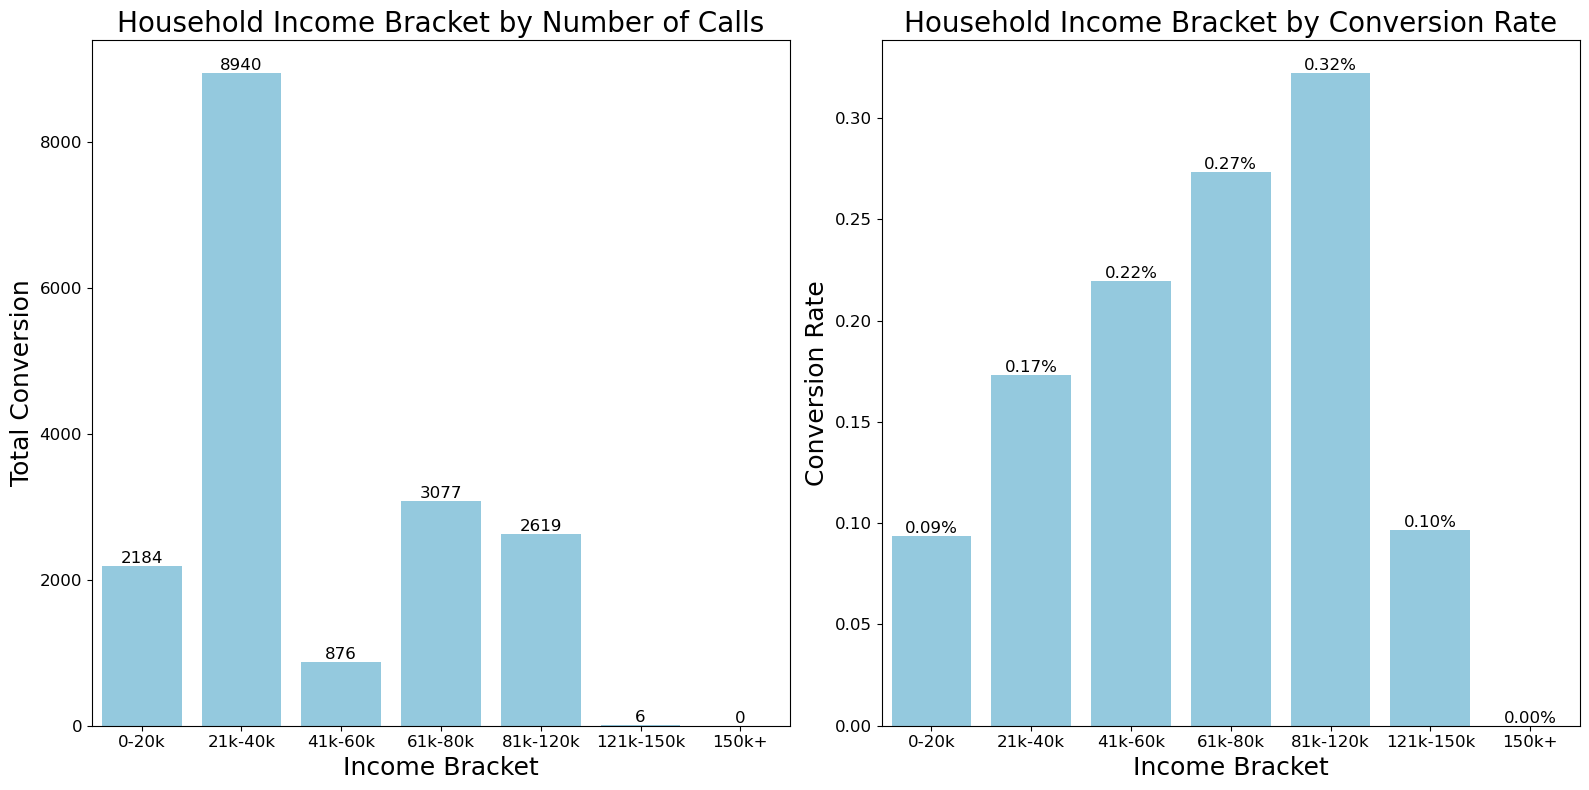

In [52]:
bin_edges = [0, 20000, 40000, 60000, 80000, 120000, 150000, float('inf')]
bin_labels = ['0-20k', '21k-40k', '41k-60k', '61k-80k', '81k-120k', '121k-150k', '150k+']
final_df['household_income_bin'] = pd.cut(final_df['household_income'], bins=bin_edges, labels=bin_labels, include_lowest=True)

income_binned_conversion = final_df.groupby('household_income_bin').agg(conversion_probabiity=('conversion_proba', 'mean'),
                                  total_converted=('conversion_pred', 'sum'),
                                  total_actions=('conversion_pred', 'count')
                            ).reset_index()
income_binned_conversion['conversion_rate'] = income_binned_conversion['total_converted']/ income_binned_conversion['total_actions'] 


fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(x='household_income_bin', y='total_converted', data=income_binned_conversion, ax=axes[0], color='skyblue')
axes[0].set_title('Household Income Bracket by Number of Calls', fontsize=20)
axes[0].set_xlabel('Income Bracket', fontsize = 18)
axes[0].set_ylabel('Total Conversion', fontsize = 18)
axes[0].bar_label(axes[0].containers[0], fontsize=12)
axes[0].tick_params(labelsize=12)

sns.barplot(x='household_income_bin', y='conversion_rate', data=income_binned_conversion, ax=axes[1], color='skyblue')
axes[1].set_title('Household Income Bracket by Conversion Rate', fontsize=20)
axes[1].set_xlabel('Income Bracket', fontsize = 18)
axes[1].set_ylabel('Conversion Rate', fontsize = 18)
axes[1].bar_label(axes[1].containers[0], fmt='%.2f%%', fontsize=12)
axes[1].tick_params(labelsize=12)

plt.tight_layout()
plt.show()

#### **Insights:**

Here we can see a better breakdown of the household incomes and which bracket they fall under.  

From earlier, we found that the callers who did convert have on average a lower household income. However, we cannot conclude just yet that lower household income callers are more valuable. If caller value is based on the metric of being more likely to convert, then the previous statement does not hold true and the bar chart showing the average household income by conversion outcome was interpreted incorrectly. 

The reason for the average income of those converted being so low is due to the fact that the majority of callers and converted callers fall within the household income range of 20k-40k. We can see this by looking at the left chart above.

Looking at the right charts above, we can see that callers with household incomes ranging from around 60k-120k have a conversion rate of about 30% which is higher than the other callers. What this means is that **these callers (~ 60k-120k household income) are more valuable** as they are more likely to convert than the other callers with a different household income range.

#### **Additionally:**

Let's take a look at the callers coming from other states once again to see if it could potentially be associated with our previous findings with regards to household income.

C:\Users\Yosua\AppData\Local\Temp\ipykernel_33720\156266854.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_bin_metrics = final_df.groupby(['household_income_bin', 'state']).agg(total_converted=('conversion_pred', 'sum'),
C:\Users\Yosua\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Yosua\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Conversion Rate per Household Income Bracket')

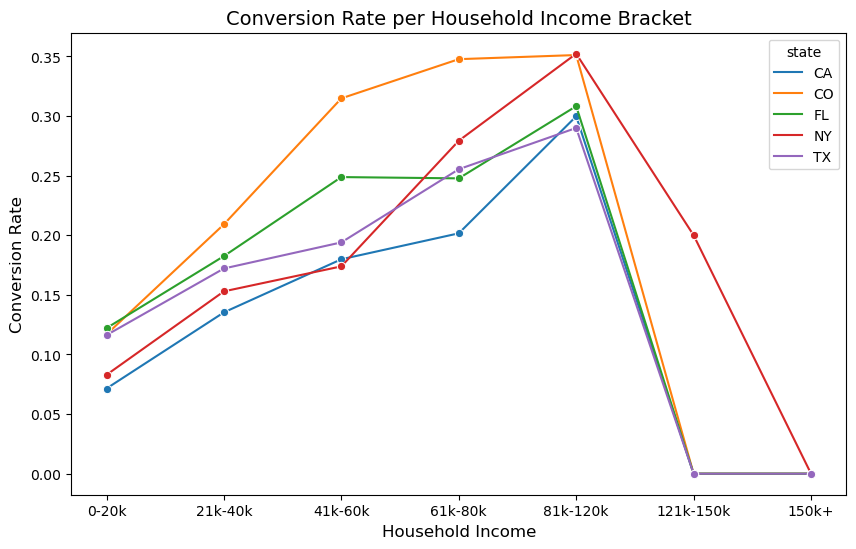

In [53]:
income_bin_metrics = final_df.groupby(['household_income_bin', 'state']).agg(total_converted=('conversion_pred', 'sum'),
                              total_action=('conversion_pred', 'count')
                            ).reset_index()
income_bin_metrics['conversion_rate'] = income_bin_metrics['total_converted']/ income_bin_metrics['total_action']
income_bin_metrics['conversion_rate'] = income_bin_metrics['conversion_rate'].fillna(0)


z = income_bin_metrics[income_bin_metrics['state'].isin(list(converted_sorted[:5].iloc[:,0]))].sort_values(by=['state', 'household_income_bin'])

plt.figure(figsize=(10, 6))
sns.lineplot(x='household_income_bin', y='conversion_rate', data=z, marker='o', linestyle='-', hue='state')

plt.xlabel('Household Income', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
#plt.xticks(rotation=90)
plt.title('Conversion Rate per Household Income Bracket', fontsize=14)

#### **Insights:**

The graph above selects the 5 states with the most converted calls, and their trends by conversion rate per household income.

The top 5 states with the most converted calls were selected for this graph due to its high volume of data, as more data is better for identifying trends.
For the most part, each states tend to follow the same trend. This backs up our previous claim stating that callers with household income ranging from 60k-120k are more 'valuable' (types of calls that are more likely to convert).

<hr style="border:5px solid Black">

<h2 style="color: blue;">Conclusion From Our Analysis:</h2>

<hr style="border:3px solid Black">

**Reminder:** 
+ Calls vary in "quality" (likelihood of purchasing a policy)
+ More likely to convert (purchase) = More valuable 

**The goal is to analyze which types of calls are more likely to convert. Here is what I found based off my analysis using our model's predicted data from task 1:**

+ Most calls that have a long duration tends to convert more likely.
+ Many "High Quality" clients are located in Colorado.
+ Clients are more likely to convert as they age up until 70 years old. Seller_id (782 and 4127) are high quality website sources to name a few.
    + After looking at 782, we found that the website traffic came majority from the state of Colorado which we conclude earlier to have high conversion rate along with high conversion count.
+ Callers who had converted have on average a lower household income than those who did not convert. However, this doesn't necessarily mean lower houshold income callers are more likely to convert.
    + **Reason:** Majority of the converted callers recorded in the data falls within the household income range of 20k-40k. This does not tell us how likely they are to convert, but instead deflates the average number in household income for callers that have converted.
    + **Actual Results:** Callers with household income within 60k-120k have conversion rate of about 30% higher, which is much higher than the other callers. In conclusion, <u>these specific type of callers, with a household income ranging from 60k-120k, are more likely to convert and is what we define as more valuable.</u>
+ The top five states with the highest number of converted callers all show similar trends in conversion rates based on household income levels.

Of course, there are additional factors to consider, such as the caller's browsing information, or a deeper dive into the timing of the calls, just to name a few. If given the total sales and spendings, we can look at metrics such as the cost of customer acquisition, cost per lead, and average order value. Exploratory Data Analysis (EDA) can offer valuable insights and help guide even further investigation!

<hr style="border:5px solid Black">

<h1 align="center"> Thank You</h1>    

<hr style="border:5px solid Black">

**Feel free to contact me:**   

**LinkedIn:** https://www.linkedin.com/in/yosua-saputra  
**Website:** https://ohayosua.github.io/yosuajsaputra/  
**Github:** https://github.com/ohayosua  
**Email:** yosua.jsaputra@gmail.com  

<h5 align="center"> This project is owned and created by Yosua Saputra  </h5> 